In [ ]:
!pip install googletrans==4.0.0-rc1

In [ ]:
!pip install spacy-wordnet

### Import the required libraries

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
import torch, torchtext
from torchtext import data
import torch.optim as optim

import os, pickle

import torch.nn as nn
import torch.nn.functional as F
import json

import re
from spacy.lang.en import English
from datetime import datetime
import googletrans
from googletrans import Translator
import spacy

from spacy_wordnet.wordnet_annotator import WordnetAnnotator 

import nltk
import math



In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Algorithm for generating the raw dataset

1.   parse the **sentiment_labels.txt** and create a dictionary of Phrase_id to label
2.   parse the **dictionary.txt** and create a dictionary of sentence to phrase_id
3.   parse the **datasetSentences.txt** and extract the string id and the comment , store this in a dataframe
4.   create a dataframe of comment and label by 
*    looping through the dataframe created in step 3
*    find if the sentence exists in the dictionary crerated in step 2
*    if yes then use the phrase id to get the label from the dictionary created in step 1 and convert the label to label category - 0 or 1 or 2 or 3 or 4 (5 sentiment label category)

Store the sentence and label category in a dataframe



## Create a class StanfordSentimentAnalysis to encapsulate methods and attributes 

### 1. Method to get the sentence and label catogory

1.  getSentenceLabelsDF(self): This method finds label for the review comment , the algorithm for the same is given below:

>>> go through the list of review comments

>>> check if the sentence exists as a phrase in the dictionary

>>>> if yes then get the phrase id and find the label for the given phrase id in labels dictionary

>>>> call getLabelIndex to get the label category i.e 0 or 1 or 2 or 3 or 4

>>> store the review comment and the label category in a data frame object


#### 1a. helper methods to get the sentence and label category

1. getLabelIndex(self , value) : This method translates the label to 5 categories based on the following range

| range of float value | integer label |
| --- | --- |
| 0 <= value <= 0.2 | **0** |
| 0.2 < value <= 0.4 | **1** |
| 0.4 < value <= 0.6 | **2** |
| 0.6 < value <= 0.8 | **3** |
| 0.8 < value <= 1.0 | **4** |

2. getSentences(self) : This method loads the **datasetSentences.txt** into a dataframe.

3. getPhraseIds(self): This method will load the **dictionary.txt** into a dictionary object

4.  getSentimentLabels(self) : This method will load the **sentiment_labels.txt** into a dictionary object

5.  getSentenceandLabels(self): This is a wrapper function which call

* getSentimentLabels()

* getPhraseIds()
    
* getSentences()

* getSentenceLabelsDF()

The result is stored in a sentence label category data frame

### 2. Data augmentation methods

7.  random_deletion(self , sentence, p=0.3): This method randomly deletes words from a sentence based on a probability.If the probability is less then a threshold , then drop the word.

8.  random_swap(self , sentence, n=3): This method randomly swaps words in a sentence.There is configurable parameter **n** which determines how many words in the sentence will be swapped.

9.  getReTranslatedSentence(self , sentence): This method uses google translation package to translate the sentence to a random destination language.Which is then retranslated to english.

10.  random_insertion(self , sentence, howmanytimes = 3): This is a wrapper method which call the removestop word and insertSynonymNTimes method.There is a configurable parameter which determines how many times a synonym will be repeated in the sentence.

#### 2a. Data augmentation helper methods

1.  getSpacyTokens(self , sentence): This is a helper method to get spacy tokens of a sentence, a rule has been included to ignore apostrophe as a separate token.

2.  removeStopWord(self, sentence): This method uses spacy token attributes to check if it is a stop word. If yes then drop the word.This method is used by insertSynonymNTimes() method to first remove stop words from the sentence.

3.  insertSynonymNTimes(self , input , numTimes):

This method is used to insert synonym for a word **n** number of times , this is a way to emphasise some words in the sentence.Wordnet library is used to get synonym for a word.The list of synonym is narrowed down based on domain.SInce these sentences are about movie , so the domain is set to celluloid etc.More about domain information can be found at domains - https://wndomains.fbk.eu/hierarchy.html



In [ ]:
class StanfordSentimentAnalysis:
  def __init__(self):

    self.sentencesDF = pd.DataFrame()
    self.phraseIdDict = {}
    self.labelsDict = {}
    self.sentencesLabelDF = pd.DataFrame()

  def getLabelIndex(self , value):

    num_of_bins= 5
    bin_width = 0.2
    bins = [0] * num_of_bins
    #print(bins)
    bin_num = -1

    if bin_width*0 <= value <= bin_width :
      bin_num = 0
    elif bin_width*1 < value <= bin_width*2 :
      bin_num = 1
    elif bin_width*2 < value <= bin_width*3 :
      bin_num = 2
    elif bin_width*3 < value <= bin_width*4 :
      bin_num = 3
    elif bin_width*4 < value <= bin_width*5 :
      bin_num = 4
    #print(value , bin_num)
    
    return bin_num  
  
  
  def getSentences(self):

    with open('/content/datasetSentences.txt','r') as sent:
      idc = 0
      sc = 0
      indexes = []
      sentiments = []
      lines = []
      for lin in sent.readlines():
    
        end = 0
        if idc == 0:
          idc += 1
          sc += 1
          continue
        if(re.search(r'\d+', lin)):
          index = re.search(r'\d+', lin)
          end = index.end()
          indexes.append(index.group())
          idc +=1
        if(re.search(r'\D+', lin)):
          sentence = lin[end+1 : ].strip()
          #print(sentence)
          sentiments.append(sentence)
          sc += 1
        assert idc == sc      
        lines.append(lin)

      self.sentencesDF["sid"] = indexes
      self.sentencesDF["comment"] = sentiments


  def getPhraseIds(self):

    with open('/content/dictionary.txt','r') as dif:
      for lin in dif.readlines():
        tok = re.split(r'\|',lin)
        self.phraseIdDict[tok[0]] = int(tok[1].strip())


  def getSentimentLabels(self):

    with open('/content/sentiment_labels.txt','r') as lbf:
      i = -1
      for lin in lbf.readlines():
        i += 1
        if i == 0:
          continue
    
        tok = re.split(r'\|',lin)          
        self.labelsDict[int((tok[0]))] = float(tok[1].strip())

  def getSentenceLabelsDF(self):

    sentiments = []
    labels = []
    i = 0
    for cmnt in self.sentencesDF.comment :

      if cmnt in self.phraseIdDict:
        phraseId = self.phraseIdDict[cmnt]
        label = self.labelsDict[phraseId]
        sentiments.append(cmnt)
        labels.append(self.getLabelIndex(label))
        i += 1

    assert i > 11000
    
    self.sentencesLabelDF['sentence'] = sentiments
    self.sentencesLabelDF['label'] = labels

    return self.sentencesLabelDF

  def getSentenceandLabels(self)        :

    self.getSentimentLabels()
    self.getPhraseIds()
    self.getSentences()

    return self.getSentenceLabelsDF()


  def getSpacyTokens(self , sentence):

    nlp = English()
    nlp.tokenizer.rules = {key: value for key, value in nlp.tokenizer.rules.items() if "'" not in key and "’" not in key and "‘" not in key}

    #  "nlp" Object is used to create documents with linguistic annotations.
    my_doc = nlp(sentence)

    # Create list of word tokens
    return [token.text for token in my_doc]


  def random_deletion(self , sentence, p=0.3): 
    global deletecounter
    start_time = datetime.now()
    words = self.getSpacyTokens(sentence)

    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    newwords = ''
    if len(remaining) == 0: # if not left, sample a random word
        newwords = [random.choice(words)] 
    else:
        newwords = remaining

    end_time = datetime.now()

    time_diff = (end_time - start_time)

    execution_time = time_diff.total_seconds() * 1000

    deletecounter = deletecounter + 1
    print( deletecounter , execution_time)

    return ' '.join(newwords)

  def random_swap(self , sentence, n=3): 
    global counter
    start_time = datetime.now()

    words = self.getSpacyTokens(sentence)

    length = range(len(words)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        #print(idx1, idx2)
        words[idx1], words[idx2] = words[idx2], words[idx1] 

    end_time = datetime.now()

    time_diff = (end_time - start_time)

    execution_time = time_diff.total_seconds() * 1000

    counter = counter + 1
    print( counter , execution_time)

    return ' '.join(words)

  def getReTranslatedSentence(self , sentence):

    global translatecounter

    start_time = datetime.now()

    translator = Translator()

    available_langs = list(googletrans.LANGUAGES.keys()) 
    trans_lang = random.choice(available_langs) 
    #print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")
    
    #print(sentence)
    translations = translator.translate(sentence, dest=trans_lang).text 

    translations_en_random = translator.translate(translations, src=trans_lang, dest='en').text 

    #print('back-',translations_en_random)

    end_time = datetime.now()

    time_diff = (end_time - start_time)

    execution_time = time_diff.total_seconds() * 1000

    translatecounter = translatecounter + 1
    print('tlt ' ,translatecounter , execution_time)

    return translations_en_random

  def removeStopWord(self, sentence):
    nlp = spacy.load('en', parser=False, entity=False)  
    nlp.tokenizer.rules = {key: value for key, value in nlp.tokenizer.rules.items() if "'" not in key and "’" not in key and "‘" not in key}
    return ' '.join([token.lemma_ for token in nlp(sentence) if not token.is_stop])

  def insertSynonymNTimes(self , input , numTimes):

    # Load an spacy model (supported models are "es" and "en") 
    nlp = spacy.load('en')
    nlp.add_pipe(WordnetAnnotator(nlp.lang), after='tagger')
    token = nlp('prices')[0]

    # wordnet object link spacy token with nltk wordnet interface by giving acces to
    # synsets and lemmas 
    token._.wordnet.synsets()
    token._.wordnet.lemmas()

    # And automatically tags with wordnet domains
    token._.wordnet.wordnet_domains()

    # Imagine we want to enrich the following sentence with synonyms
    sentence = nlp(input)

    # spaCy WordNet lets you find synonyms by domain of interest
    # for example economy
    #movie_domains = ['banking', 'finance','cinema']
    movie_domains = ['film', 'music' , 'celluloid' ,'play', 'sport', 'history' , 'literature', 'banking' , 'finance' ,'cinema']
    enriched_sentence = []
    

    # For each token in the sentence
    for token in sentence:
      #print('idx-',token.i)
      # We get those synsets within the desired domains
      synsets = token._.wordnet.wordnet_synsets_for_domain(movie_domains)
      #synsets = token._.wordnet.synsets()
      if synsets:
          lemmas_for_synset = []
          for s in synsets:
            # If we found a synset in the economy domains
            # we get the variants and add them to the enriched sentence
            #print(s.lemma_names())
            lemmas_for_synset.extend(s.lemma_names())
            if (len(lemmas_for_synset) > 1):
              #print('lfors-',lemmas_for_synset[1:])
              #enriched_sentence.append('({})'.format('|'.join(set(lemmas_for_synset))))
              ntimes = (random.choice(lemmas_for_synset[1:]) + ' ')*numTimes
              #print(ntimes)
              enriched_sentence.append(ntimes)
            else:
              enriched_sentence.append(token.text)
      else:
        enriched_sentence.append(token.text)
        #mod_sent.append(token.text)

    # Let's see our enriched sentence
    return ' '.join(enriched_sentence)
          

  def random_insertion(self , sentence, howmanytimes = 3): 

    global insertcounter
    start_time = datetime.now()

    newSentence = self.removeStopWord(sentence) 
    synmsentence =  self.insertSynonymNTimes(newSentence,howmanytimes)

    end_time = datetime.now()

    time_diff = (end_time - start_time)

    execution_time = time_diff.total_seconds() * 1000
    
    insertcounter = insertcounter + 1
    print('ins', insertcounter , execution_time)

    return synmsentence 

### Pre processing data

The following section of the code is commented, it is shown here to help understand the data pre processing done to generate the sentiment analysis dataset and then apply 4 augmentation methods to generate augmented data.The final dataset was pre processed in a separate notebook and is used here directly to save the pre processing time.

In [ ]:
"""sa = StanfordSentimentAnalysis()
sldf = sa.getSentenceandLabels()
sldf.head()"""

,sentence,label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Effective but too-tepid biopic,2
3,If you sometimes like to go to the movies to h...,3
4,"Emerges as something rare , an issue movie tha...",4


### This is a wrapper method to call different augmentation methods 

In [ ]:
"""def augmentStanfordSentimentAnalysisData(sentAnlysDF , method):

  swapSentence = sentAnlysDF.sentence.apply(method)
  swapLabel = sentAnlysDF.label

  swapDF = pd.concat([swapSentence, swapLabel], axis=1)

  return swapDF"""
  


### This is a call to apply **random_swap** augmentation method on the base dataset

In [ ]:
"""augDF = augmentStanfordSentimentAnalysisData(sldf , sa.random_swap)
len(augDF)"""

### The augmented data is appended to the base dataset

In [ ]:
"""orig_swapDF =  pd.concat([sldf , augDF],ignore_index=True)"""

### This is a call to apply **random_deletion** augmentation method on the base dataset

In [ ]:
"""augDelDF = augmentStanfordSentimentAnalysisData(sldf , sa.random_deletion)
len(augDelDF)"""

### Augmented data is appended to base + random swapped dataset

In [ ]:
"""orig_swap_delDF =  pd.concat([orig_swapDF , augDelDF],ignore_index=True)"""

### This is a call to apply **translation - from english to a random language and back to english** augmentation method on the base dataset

In [ ]:
"""augtrnsltDF = augmentStanfordSentimentAnalysisData(sldf , sa.getReTranslatedSentence)
len(augtrnsltDF)"""

### Augmented data is appended to base + random swapped + random deletion dataset

In [ ]:
"""orig_swap_del_tltDF =  pd.concat([orig_swap_delDF , augtrnsltDF],ignore_index=True)"""

### This is a call to apply **random_insertion** augmentation method on the base dataset

In [ ]:
"""auginsertDF = augmentStanfordSentimentAnalysisData(sldf , sa.random_insertion)
len(auginsertDF)"""

### Augmented data is appended to base + random swapped + random deletion + random translation dataset

In [ ]:
"""orig_swap_del_tlt_insDF =  pd.concat([orig_swap_del_tltDF , auginsertDF],ignore_index=True)"""

### Pre processed data is loaded here directly 

In [ ]:
df = pd.read_csv("/content/orig_swap_del_tlt_insDF.csv")

### helper method to clean the string

source - https://github.com/anirbanmukherjee2709/tsai_end2.0_Session_5/blob/main/Stanford%20Sentiment%20Tree%20Bank/Stanford_sentiment_treebank.ipynb

In [ ]:
def clean_data(x):
    char_dict = {
        '-LRB-' : '(',
        '-RRB-' : ')',
        '\xa0' : ' ',
        '\xc2' : '',
        '\xc3\x83\xc2\xa0' : 'a',
        'à' : 'a',
        'Â' : '',
        'â' : 'a',
        'ã' : 'a',
        'Ã¡' : 'a',
        'Ã¢' : 'a',
        'Ã£' : 'a',
        'Ã¦' : 'ae',
        'Ã§' : 'c',
        'Ã¨' : 'e',
        'Ã©' : 'e',
        'Ã­' : 'i',
        'Ã¯' : 'i',
        'Ã±' : 'n',
        'Ã³' : 'o',
        'Ã´' : 'o',
        'Ã¶' : 'o',
        'Ã»' : 'u',
        'Ã¼' : 'u',
        'æ' : 'ae',
        'ç' : 'c',
        'è' : 'e',
        'é' : 'e',
        'í' : 'i',
        'ï' : 'i',
        'ñ' : 'n',
        'ó' : 'o',
        'ô' : 'o',
        'ö' : 'o',
        'û' : 'u',
        'ü' : 'u'
    }
    for keys in char_dict.keys():
        x = x.replace(keys, char_dict[keys])
    return x

### Apply data cleaning on the augmented dataset

In [ ]:
df['cleansentence'] = df['sentence'].apply(lambda x: clean_data(x))

### get the final dataset

In [ ]:
df = df.drop(columns=['sentence'])
df = df.rename(columns={"cleansentence": "sentence"})
df.head()

,label,sentence
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,2,Effective but too-tepid biopic
3,3,If you sometimes like to go to the movies to h...
4,4,"Emerges as something rare , an issue movie tha..."


#### The labels are normalized into 5 categories based on the following rule

1.   *0 <= If the rating is  <= 0.2 - label is 0* which is mapped to **Very negative**
2.   *0.2 < If the rating is  <= 0.4 - label is 1* which is mapped to **negative**

3.   *0.4 < If the rating is  <= 0.6 - label is 2* which is mapped to **neutral**

4.   *0.6 < If the rating is  <= 0.8 - label is 3* which is mapped to **positive**

5.   *0.8 < If the rating is  <= 1.0 - label is 4* which is mapped to **Very positive**





In [ ]:
df.tail()

,label,sentence
56425,0,real snooze .
56426,1,surprise .
56427,3,' ve see see see see_to_it see_to_it see_to_i...
56428,0,rooter rooter rooter walk walk walk walk wal...
56429,1,instance instance instance example example ex...


### The final dataset has **56430** records

In [ ]:
df.shape

(56430, 2)

### A quick glance of the label statistics

Majority of the comments have a label of **negative or positive or neutral**  , users avoid giving outlier labels like **Very negative or Very positive**.

In [ ]:
df.label.value_counts()

1    14855
3    14830
2    10720
4     8865
0     7160
Name: label, dtype: int64

In [ ]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

### Create Field and LabelField variables to hold the comment and label information

**Field** - Defines a datatype together with instructions for converting to Tensor.

Field class models common text processing datatypes that can be represented by tensors. It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations. The Field object also holds other parameters relating to how a datatype should be numericalized, such as a tokenization method and the kind of Tensor that should be produced.

1.   The comment will be stored in **Sentence** Field object
2.   The label will be stored in **Label** LabelField object


In [ ]:
Sentence = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

#### Map the 2 variables to column header 

| Column header | Variable name |
| --- | --- |
| **sentence** | Sentence |
| **label** | Label |

In [ ]:
fields = [('sentence', Sentence), ('label', Label)]

### Create a list of example

by doing list comprehension of the sentence and label dataframe generated from the preprocessed csv file

In [ ]:
example = [torchtext.legacy.data.Example.fromlist([df.sentence[i],df.label[i]], fields) for i in range(df.shape[0])] 

### Create the Dataset 

by providing the above list of examples and the field mapping

In [ ]:
stanfordDataset = torchtext.legacy.data.Dataset(example, fields)

In [ ]:
stanfordDataset

### Split the dataset into

train and test in the ratio of **70:30**

In [ ]:
(train, test) = stanfordDataset.split(split_ratio=[70, 30], random_state = random.seed(SEED))

In [ ]:
len(train), len(test)

(39501, 16929)

In [ ]:
train.fields

{'label': <torchtext.legacy.data.field.LabelField at 0x7f398c6f1050>,
 'sentence': <torchtext.legacy.data.field.Field at 0x7f398d4bbc10>}

#### a quick glance of one train record

In [ ]:
vars(train.examples[15])

{'label': 4,
 'sentence': ['Maud',
  'and',
  'Roland',
  "'s",
  'search',
  'for',
  'an',
  'unknowable',
  'past',
  'makes',
  'for',
  'a',
  'haunting',
  'literary',
  'detective',
  'story',
  ',',
  'but',
  'LaBute',
  'pulls',
  'off',
  'a',
  'neater',
  'trick',
  'in',
  'Possession',
  ':',
  'He',
  'makes',
  'language',
  'sexy',
  '.']}

A Vocab object defines the set of possible values for elements of the field and their corresponding numerical representations.

Create Vocab object of the review comments and labels

In [ ]:
Sentence.build_vocab(train)
Label.build_vocab(train)

In [ ]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('label : ', Label.vocab.stoi)

Size of input vocab :  28751
Size of label vocab :  5
Top 10 words appreared repeatedly : [(' ', 61474), ('.', 34925), (',', 30820), ('the', 21658), ('-', 15754), ('of', 15166), ('and', 14994), ('a', 14778), ('to', 10308), ("'", 10189)]
label :  defaultdict(None, {3: 0, 1: 1, 2: 2, 4: 3, 0: 4})


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### set the batch size

In [ ]:
batch_size =  64

### Use the BucketIterator to split and create 

1.   train iterator
2.   test iterator



In [ ]:
train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits((train, test), 
                                                                             
                                                                             batch_size = batch_size, 
                                                            # Function to use for sorting examples.
                                                            sort_key = lambda x: len(x.sentence),
                                                            # Shuffle data on each epoch run.
                                                            shuffle=True,
                                                            # Use `sort_key` to sort examples in each batch.
                                                            sort_within_batch=True, 
                                                            device = device)

### Save the Vocab object for later use during testing

In [ ]:
with open('sentencetokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

### Model class for training and testing

The model has

1.   An embedding layer which stores the list of words seen in the dataset and has weights attached to each word.These weights are adjusted during backpropagation to enable the model to converge at global minimum.
2.   pack padded sequence method is used to pad the sentences and create sentence of same length equal to the longest sentence in the batch.
3.   A 2 layer GRU to process the sentence
4.   A fully connected layer to output 5 states , which will map to 5 labels in the dataset.

In [ ]:
class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, bi_direction = False):
        
        super().__init__()          
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bi_direction
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.GRU(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True,
                           bidirectional=self.bidirectional)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # initialize the hidden state
        multiplier = 1
        if self.bidirectional:
          multiplier = 2

        hidden = torch.zeros( multiplier*self.n_layers , text.size(0), self.hidden_dim)
        hidden = hidden.to(device)
        
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        #packed_output,( hidden , cell) = self.encoder(packed_embedded )
        packed_output, hidden = self.encoder(packed_embedded , hidden)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

### Set the hyperparameters before running the model

1.   dropout
2.   number of nodes in embedding layer
3.   number of nodes in hidden layer
4.   number of layers in GRU


In [ ]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 200
num_output_nodes = len(Label.vocab)
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout,bi_direction=False)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(28751, 300)
  (encoder): GRU(300, 200, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=200, out_features=5, bias=True)
)
The model has 9,168,705 trainable parameters


### A utility function to calculate the model accuracy

In [ ]:
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

### wrapper function to train the model

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence  
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### wrapper function to evaluate the model

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Run the model over few epochs to see the model performance

In [ ]:
N_EPOCHS = 20
best_test_loss = float('inf')

trainLossList = []
valLossList = []

trainAccyList = []
valAccyList = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    
    # save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'sentence_saved_weights.pt')
    
    trainLossList.append(round(train_loss,2))
    valLossList.append(round(test_loss,2))

    trainAccyList.append(round(train_acc,2))
    valAccyList.append(round(test_acc,2))

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% \n')

	Train Loss: 1.564 | Train Acc: 30.57%
	 Val. Loss: 1.538 |  Val. Acc: 34.71% 

	Train Loss: 1.504 | Train Acc: 38.84%
	 Val. Loss: 1.497 |  Val. Acc: 39.29% 

	Train Loss: 1.453 | Train Acc: 44.38%
	 Val. Loss: 1.471 |  Val. Acc: 42.14% 

	Train Loss: 1.403 | Train Acc: 49.85%
	 Val. Loss: 1.447 |  Val. Acc: 44.71% 

	Train Loss: 1.355 | Train Acc: 54.99%
	 Val. Loss: 1.428 |  Val. Acc: 46.66% 

	Train Loss: 1.310 | Train Acc: 59.74%
	 Val. Loss: 1.407 |  Val. Acc: 48.87% 

	Train Loss: 1.272 | Train Acc: 63.64%
	 Val. Loss: 1.390 |  Val. Acc: 50.60% 

	Train Loss: 1.238 | Train Acc: 67.23%
	 Val. Loss: 1.373 |  Val. Acc: 52.45% 

	Train Loss: 1.207 | Train Acc: 70.43%
	 Val. Loss: 1.362 |  Val. Acc: 53.53% 

	Train Loss: 1.181 | Train Acc: 73.14%
	 Val. Loss: 1.351 |  Val. Acc: 54.65% 

	Train Loss: 1.157 | Train Acc: 75.52%
	 Val. Loss: 1.342 |  Val. Acc: 55.50% 

	Train Loss: 1.136 | Train Acc: 77.52%
	 Val. Loss: 1.336 |  Val. Acc: 56.32% 

	Train Loss: 1.119 | Train Acc: 79.22%
	

### A graph of model performance 

1.   Training and testing accuracy across different epochs
2.   Training and testing loss across different epochs



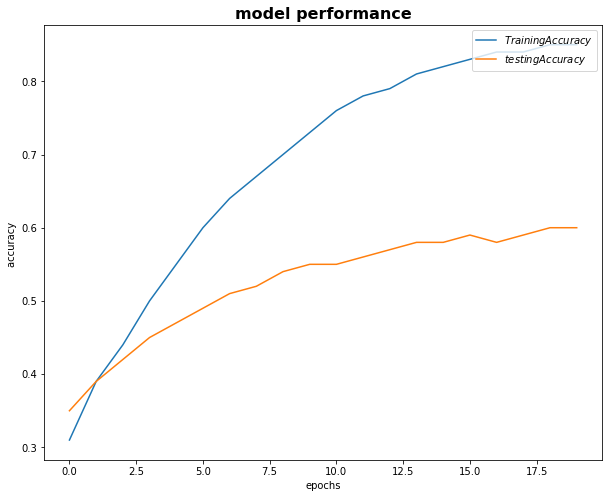

In [ ]:
xpoints = np.arange(len(trainLossList))
ypoints4 = trainAccyList
ypoints6 = valAccyList

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(xpoints, ypoints4, label = "$ Training Accuracy $" )
plt.plot(xpoints, ypoints6, label = "$ testing Accuracy $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("accuracy ")
plt.show()

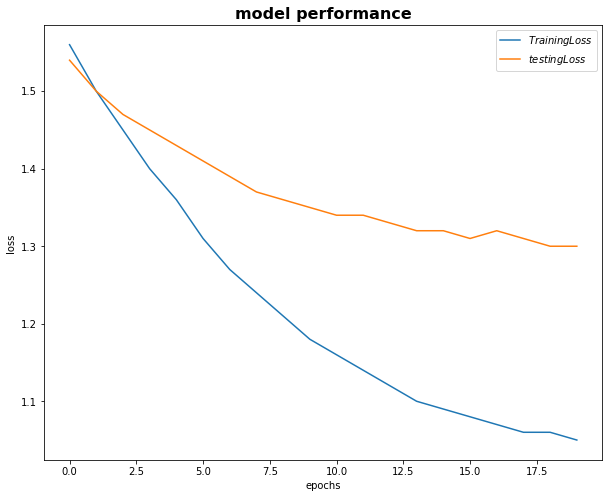

In [ ]:
xpoints = np.arange(len(trainLossList))
ypoints0 = trainLossList
ypoints2 = valLossList


plt.rcParams['figure.figsize'] = [10,8]
plt.plot(xpoints, ypoints0 , label = "$ Training Loss $" )
plt.plot(xpoints, ypoints2, label = "$ testing Loss $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("loss ")
plt.show()

### A utility function to classify any sentence

1.   saved weights are used to classify any input string to predict a label
2.   a cached tokenizer which was saved earlier is used


In [ ]:
#load weights and tokenizer

path='./sentence_saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('/content/sentencetokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

categories = {0: "very negative", 1: "negative", 2: "neutral", 3: "positive", 4: "very positive"}
    
def classify_sentence(sentence):
    
    # tokenize the review comment
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [ ]:
classify_sentence("The camera twirls ! Oh , look at that ! Wow , a jump cut !")

'neutral'

## Testing the model on 10 random review comments from the test set to predict the label

In [ ]:
import random 

from IPython.display import display, Markdown

TESTSAMPLE = 10

testindex = np.arange (len(test))


randindex = random.choices(testindex , k=10)
  
for i in range(TESTSAMPLE)  :

  out = vars(test.examples[randindex[i]])
  
  true_label = categories[out['label']]
  in_sentence = ' '.join(out['sentence'])
  pred_label = classify_sentence(in_sentence)

  strTruelabel = 'True label: ' + str(true_label)
  strPredlabel = 'Predicted label: ' +  str(pred_label)
  strSentence =  'Input Sentence: ' + in_sentence
  lineSeparator = '---------------------------------'
  display(Markdown('<strong>{}</strong><br><br><strong>{}</strong><br><br>{}<br><br><strong>{}</strong><br><br>'.format(strTruelabel , strPredlabel , strSentence , lineSeparator)))






<strong>True label: neutral</strong><br><br><strong>Predicted label: neutral</strong><br><br>Input Sentence: ape go you this over Will movie ?<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: negative</strong><br><br><strong>Predicted label: very positive</strong><br><br>Input Sentence: However , fliems are their lights , however , in the distribution of the Disney phososophy required , greeting I wish to avoid .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: very positive</strong><br><br><strong>Predicted label: positive</strong><br><br>Input Sentence: Miyazaki 's nonstop images are so stunning , and his imagination so vivid , that the only possible complaint you could have about Spirited Away is that there is no rest period , no timeout .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: neutral</strong><br><br><strong>Predicted label: neutral</strong><br><br>Input Sentence: Can not get anywhere near the center of the story .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: negative</strong><br><br><strong>Predicted label: negative</strong><br><br>Input Sentence: This is the Rotel Drive to my mother and father 's wallet .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: positive</strong><br><br><strong>Predicted label: very negative</strong><br><br>Input Sentence: Those do n't entirely ` ' Godard ' s distinctive discourse will still come with sense of reserved but existential poignancy .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: negative</strong><br><br><strong>Predicted label: negative</strong><br><br>Input Sentence: If we do not require the quality standard for the art we choose , we deserve the garbage we get .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: neutral</strong><br><br><strong>Predicted label: neutral</strong><br><br>Input Sentence: you ' not totally - the notion community therapy spectacle Quitting hits home with force .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: negative</strong><br><br><strong>Predicted label: negative</strong><br><br>Input Sentence: For a shoot - 'em - up , Ballistic is oddly lifeless .<br><br><strong>---------------------------------</strong><br><br>

<strong>True label: neutral</strong><br><br><strong>Predicted label: neutral</strong><br><br>Input Sentence: The is reasonably well - done yet character and bits are to ever smoothly together .<br><br><strong>---------------------------------</strong><br><br>

# The model could predict 7 label correctly out of 10 from the test dataset

In [ ]:
diagnosticDict = {}

diagnosticDict['num_hidden_nodes'] = num_hidden_nodes
diagnosticDict['num_layers'] = num_layers
diagnosticDict['dropout'] = dropout
diagnosticDict['trainLossList'] = trainLossList
diagnosticDict['valLossList']= valLossList
diagnosticDict['trainAccyList'] = trainAccyList
diagnosticDict['valAccyList'] = valAccyList
diagnosticDict['batchsize'] = batch_size

#diagnosticDict

In [ ]:
import json

out_file = open("lstmdiagnostic.json", "a")
  
json.dump(diagnosticDict, out_file, indent = 6)
  
out_file.close()

### Load the diagnostics dump for model performance without data augmentation

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np



In [21]:
with open('./alllstmdiagnostic.json') as f:
  data = json.load(f)
  


## Diagnostics

The model was run several times with different dropout values , a plot of the model performance across these runs is shown below.


In [22]:
def plotmodelperformance(data):

  for i in range(len(data)):

    my1 = data[i]['trainAccyList']
    my2 = data[i]['valAccyList']
    my3 = data[i]['trainLossList']
    my4 = data[i]['valLossList']
    mx = np.arange(len(my1))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.suptitle('Model performance w.r.t epochs = ' + str(len(data[i]['trainLossList'])) + ', dropout ='+ str(data[i]['dropout']) + ', number of LSTM layers =' + str(data[i]['num_layers']) + ', batch size =' + str(data[i]['batchsize']), fontsize=26)
    fig.set_figwidth(19)
    #fig.tight_layout(pad = 2.0)

    line1, = ax1.plot(mx, my1, label='trng accy')
    line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

    # Using plot(..., dashes=...) to set the dashing when creating a line
    line2, = ax1.plot(mx, my2 , label='val accy')

    line3, = ax2.plot(mx, my3, label='trng loss')
    line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

    # Using plot(..., dashes=...) to set the dashing when creating a line
    line4, = ax2.plot(mx, my4 , label='val loss')

    #ax1.title("model performance", fontsize=16, fontweight='bold')
    ax1.set_xlabel("epochs" , fontsize=20)
    ax1.set_ylabel("accy " , fontsize=20)
    ax2.set_xlabel("epochs" , fontsize=20)
    ax2.set_ylabel("loss " , fontsize=20)
    #ax.legend()
    plt.show()



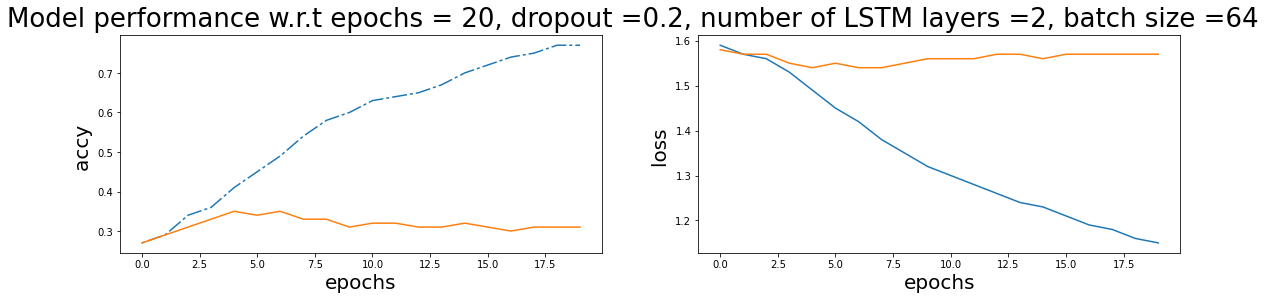

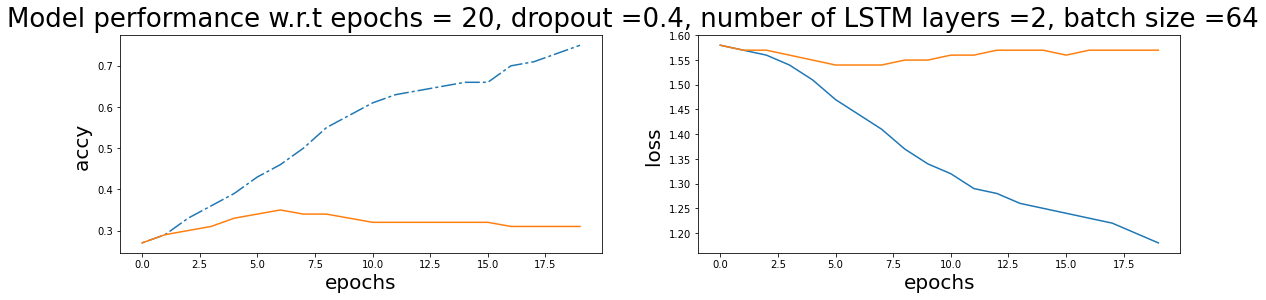

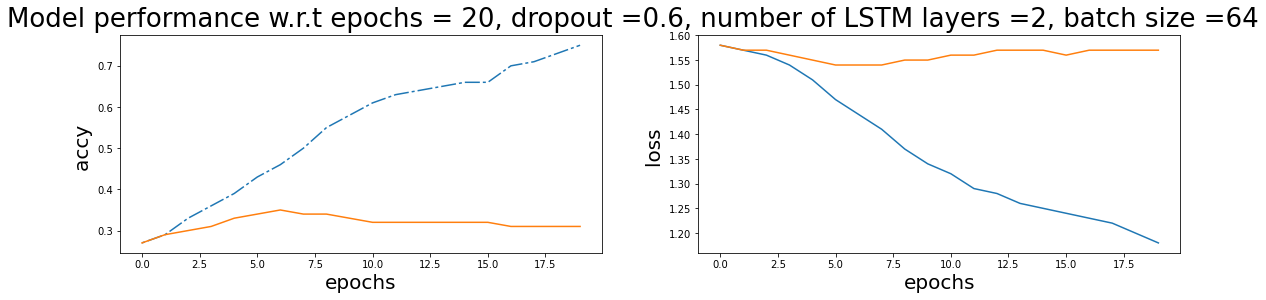

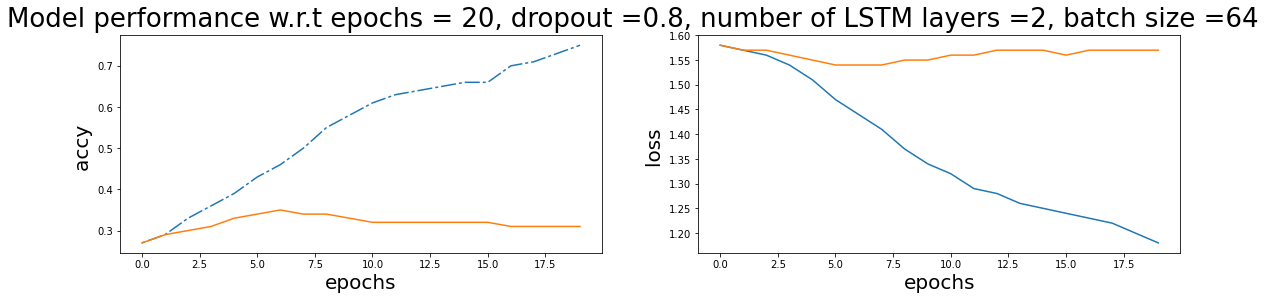

In [23]:
plotmodelperformance(data)

In [24]:
with open('./augmented_lstmdiagnostic.json') as f:
  augmenteddata = json.load(f)


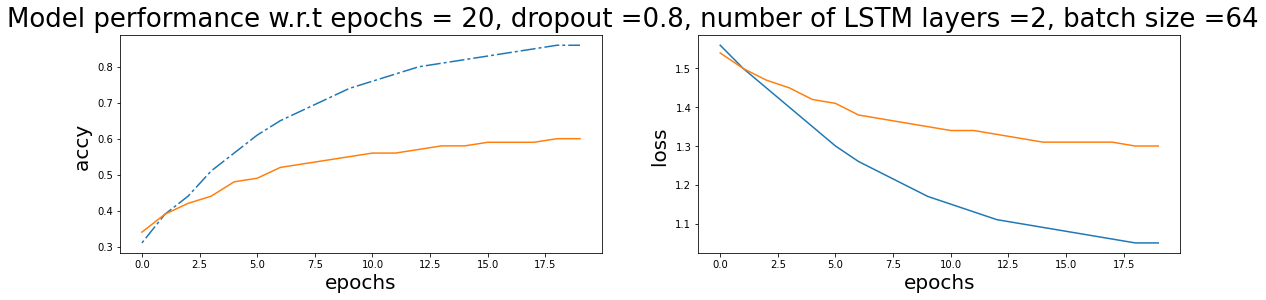

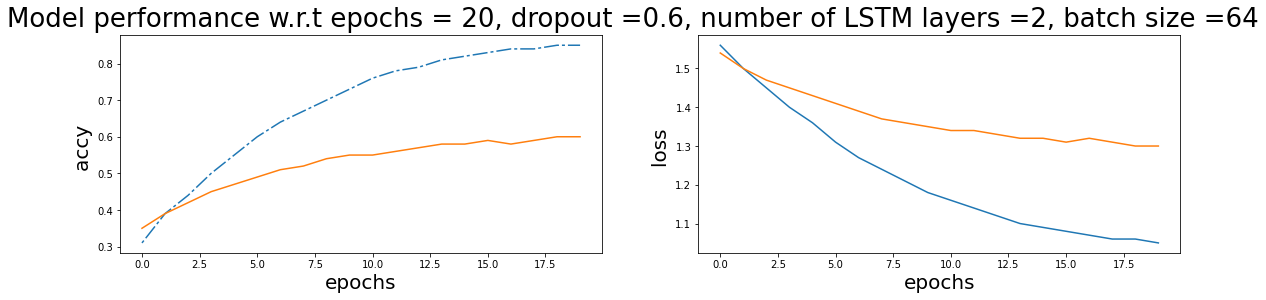

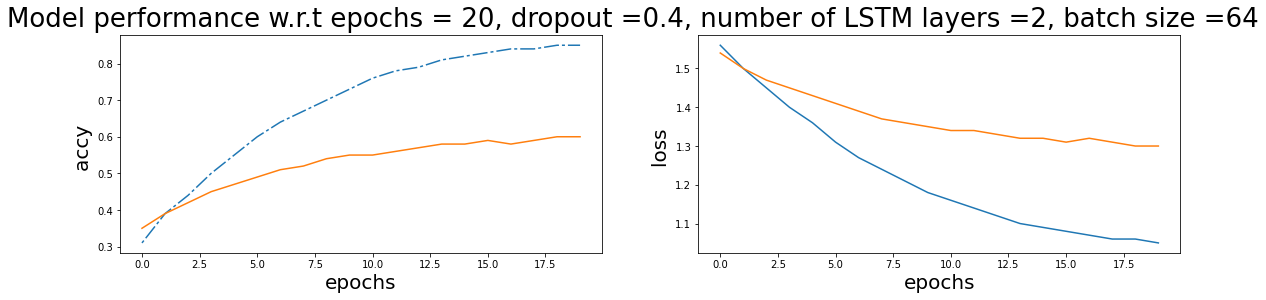

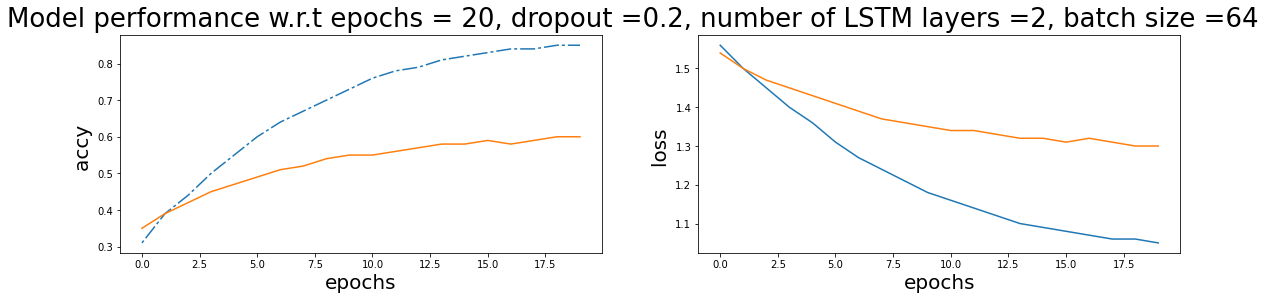

In [25]:
plotmodelperformance(augmenteddata)

# Summary

| Performance metrics | without **Augmentation**  | with **Augmentation** |
| --- | --- | --- |
| Training accuracy | **75-77%** | **85%** |
| Test accuracy | **31%** | **60%** |
| Training loss | **1.18** | **1.05** |
| Test loss | **1.57** | **1.3** |

The biggest impact is seen in test accuracy , with augmentation accuracy improved from 31% to **60%**.

Dropout did regularize during training but the model could not improve its performance.Will try other hyper parameter tuning to improve model performance.

